In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

df = pd.read_csv('samples_nylonGuitar_1024_Mm7_R03.csv')

X = np.array(df.iloc[:,:-1], dtype=np.float)
y = np.array(df.iloc[:,-1], dtype=np.float)

In [3]:
import os

processedData_path = "preprocessedSamples.data"

if os.path.isfile(processedData_path): #if already preprocessed
    df_new = pd.read_pickle(processedData_path)
else:
    for i in range(len(X)):
        sample = np.array(X[i], dtype=np.float)
        sample = sample*np.hamming(1024)
        sample = np.abs(np.fft.rfft(sample))[1:]
        sample = np.append(sample, y[i])
        try:
            df_new = np.vstack([df_new, sample])
        except:
            df_new = np.array(sample, dtype=np.float)
        if i % 200 == 0:
            print(i)
            df_new[i]
    
    df_new = pd.DataFrame(df_new)
    
    df_new.to_pickle(processedData_path)

1.0
0.0


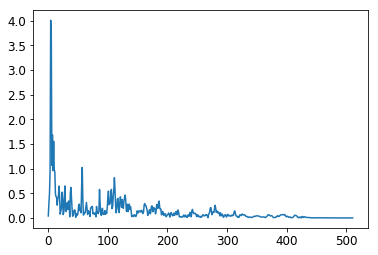

In [11]:
import matplotlib.pyplot as plt

npArrayDF = np.array(df_new.iloc[:,:], dtype=np.float) #shuffle randomly all samples

print(npArrayDF[0,-1])

for i in range(len(npArrayDF)):
    npArrayDF[i,-1] = (npArrayDF[i, -1]) - 1

print(npArrayDF[0,-1])
    
np.random.shuffle(npArrayDF)

X_train = np.array(npArrayDF[:-2000,:-1], dtype=np.float)
y_train = np.array(npArrayDF[:-2000,-1], dtype=np.float)

X_valid = np.array(npArrayDF[-2000:-1000,:-1], dtype=np.float)
y_valid = np.array(npArrayDF[-2000:-1000,-1], dtype=np.float)

plt.plot(X_train[1])
plt.show()

In [34]:
reset_graph()

n_inputs = 512
n_hidden1 = 300
n_hidden2 = 100
n_outputs += 1

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [35]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [36]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [37]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [38]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [39]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [40]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range((len(X_train)+len(X_test)) // batch_size):
            sess.run(training_op, feed_dict={X: X_train, y: y_train})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_test = accuracy.eval(feed_dict={X: X_test,
                                            y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")
    

0 Train accuracy: 0.940373 Test accuracy: 0.841
1 Train accuracy: 0.985214 Test accuracy: 0.851
2 Train accuracy: 0.990547 Test accuracy: 0.849
3 Train accuracy: 0.993052 Test accuracy: 0.833
4 Train accuracy: 0.99491 Test accuracy: 0.821
5 Train accuracy: 0.897471 Test accuracy: 0.819
6 Train accuracy: 0.972126 Test accuracy: 0.826
7 Train accuracy: 0.98683 Test accuracy: 0.826
8 Train accuracy: 0.992082 Test accuracy: 0.821
9 Train accuracy: 0.995799 Test accuracy: 0.816
10 Train accuracy: 0.437586 Test accuracy: 0.423
11 Train accuracy: 0.855054 Test accuracy: 0.756
12 Train accuracy: 0.919609 Test accuracy: 0.78
13 Train accuracy: 0.949099 Test accuracy: 0.788
14 Train accuracy: 0.965985 Test accuracy: 0.795
15 Train accuracy: 0.977781 Test accuracy: 0.796
16 Train accuracy: 0.93601 Test accuracy: 0.793
17 Train accuracy: 0.987719 Test accuracy: 0.804
18 Train accuracy: 0.99184 Test accuracy: 0.804
19 Train accuracy: 0.994021 Test accuracy: 0.8
20 Train accuracy: 0.996203 Test accu

26.0


In [48]:
Y_proba=tf.argmax(logits,1)

feed_dict = {X: np.reshape(X_test[1],(1,512))}
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    y = Y_proba.eval(feed_dict=feed_dict)
    print(y)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[26]


In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./chord_recognizer_model.ckpt")
    y = (Y_proba.eval(feed_dict={X:X_test}))
    print(y)

INFO:tensorflow:Restoring parameters from ./chord_recognizer_model.ckpt
[[  5.29848018e-27   6.02447337e-20   2.01454312e-23 ...,   6.03477020e-30
    8.68241493e-30   0.00000000e+00]
 [  2.24837374e-22   4.61395848e-38   8.41620416e-26 ...,   2.81289287e-15
    3.71592485e-18   5.36249693e-18]
 [  6.35865050e-08   6.91016827e-11   6.21579180e-17 ...,   2.46286880e-10
    2.03620475e-18   1.81750500e-11]
 ..., 
 [  0.00000000e+00   0.00000000e+00   1.25717458e-37 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.20730035e-19   3.46691281e-35   1.35972608e-19 ...,   4.53987398e-34
    2.90763285e-33   2.08454041e-34]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.91360724e-31   9.95101785e-25]]


In [51]:
print(len(np.unique(y_train))

12377
